In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from IPython.display import display
from sklearn.model_selection import (GridSearchCV, ParameterGrid,
                                     RandomizedSearchCV)
from xgboost import XGBClassifier
import pickle
import random
from tqdm.notebook import trange, tqdm

from tools import Modelisation, datasets, SearchCV, restauration_CV, graph_2scores_CV, graph_param_CV, best_score_CV

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


In [4]:
len(y[y == 0]) / (len(y[y == 1]))

16.552685500043594

# XGBoost
## Variables quantitatives

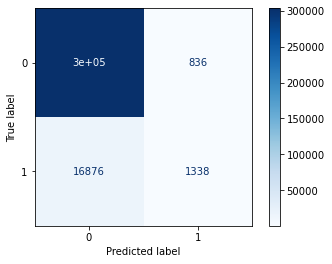

f1 : 0.1313
recall : 0.0735
negative predictive value : 0.9473
precision : 0.6155
roc_auc : 0.8269
CPU times: user 8min 9s, sys: 1.89 s, total: 8min 11s
Wall time: 19.6 s


In [5]:
%%time
m = Modelisation(X_quant, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

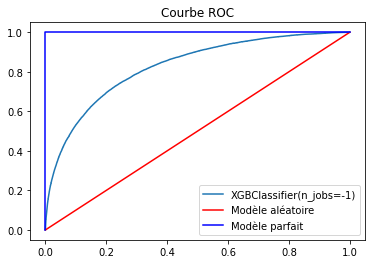

In [6]:
m.show_ROC()

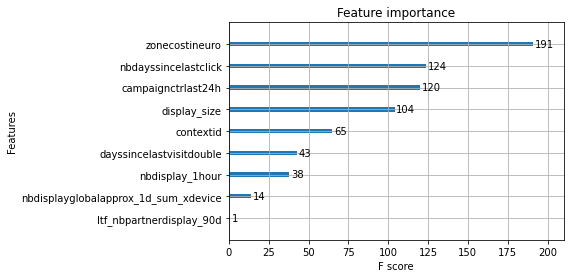

In [7]:
m.plot_importance()

Affichage d'un arbre (par défaut le premier parmi les autres) :

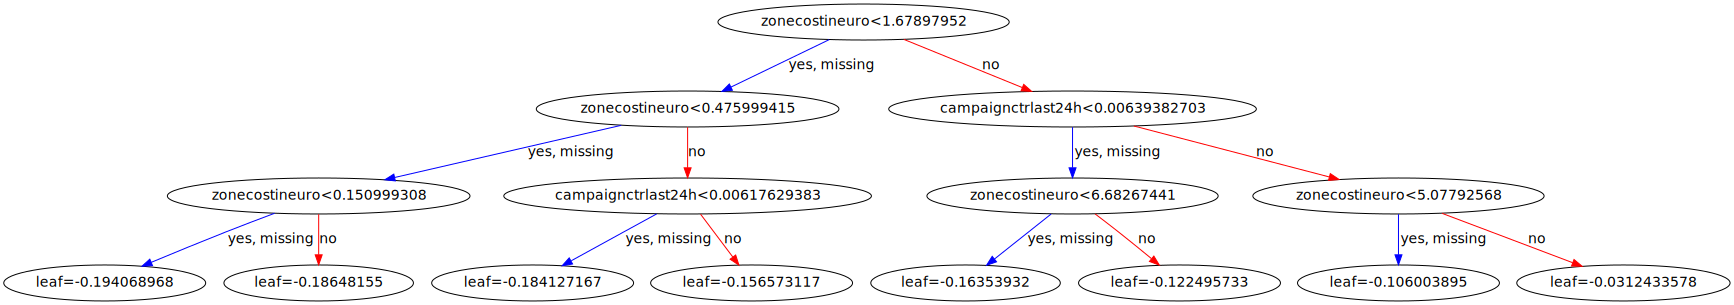

In [8]:
m.show_graph()

## Variables catégorielles

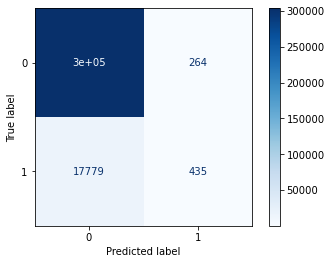

f1 : 0.0460
recall : 0.0239
negative predictive value : 0.9447
precision : 0.6223
roc_auc : 0.6937
CPU times: user 11min 49s, sys: 4.1 s, total: 11min 53s
Wall time: 18.2 s


In [9]:
%%time
m = Modelisation(X_cat, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

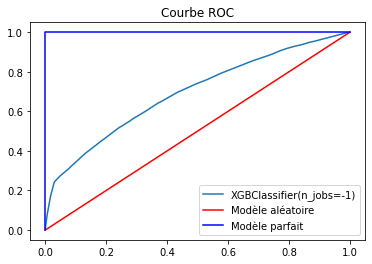

In [10]:
m.show_ROC()

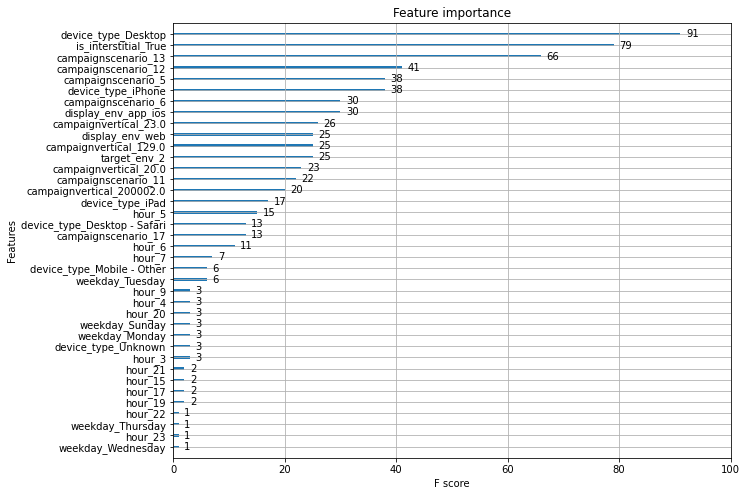

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
m.plot_importance(ax=ax)

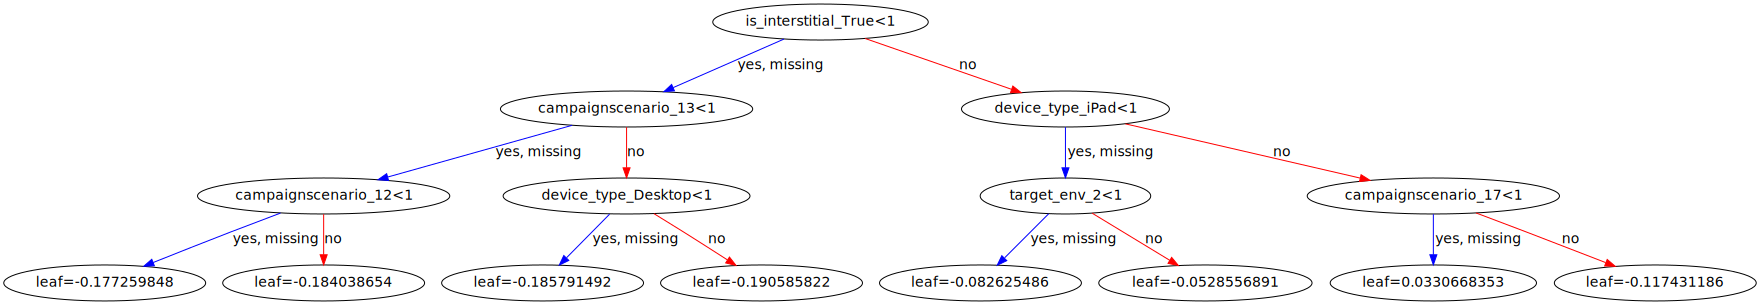

In [12]:
m.show_graph()

## Variables quantitatives + catégorielles

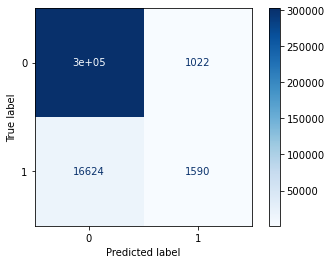

f1 : 0.1527
recall : 0.0873
negative predictive value : 0.9480
precision : 0.6087
roc_auc : 0.8337
CPU times: user 12min 17s, sys: 3.88 s, total: 12min 21s
Wall time: 24.1 s


In [13]:
%%time
m = Modelisation(X, y, XGBClassifier(n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

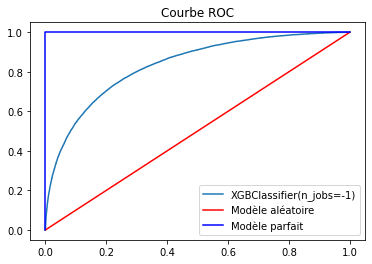

In [14]:
m.show_ROC()

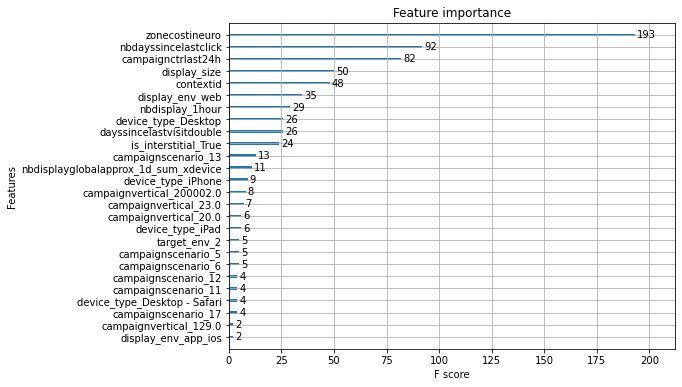

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
m.plot_importance(ax=ax)

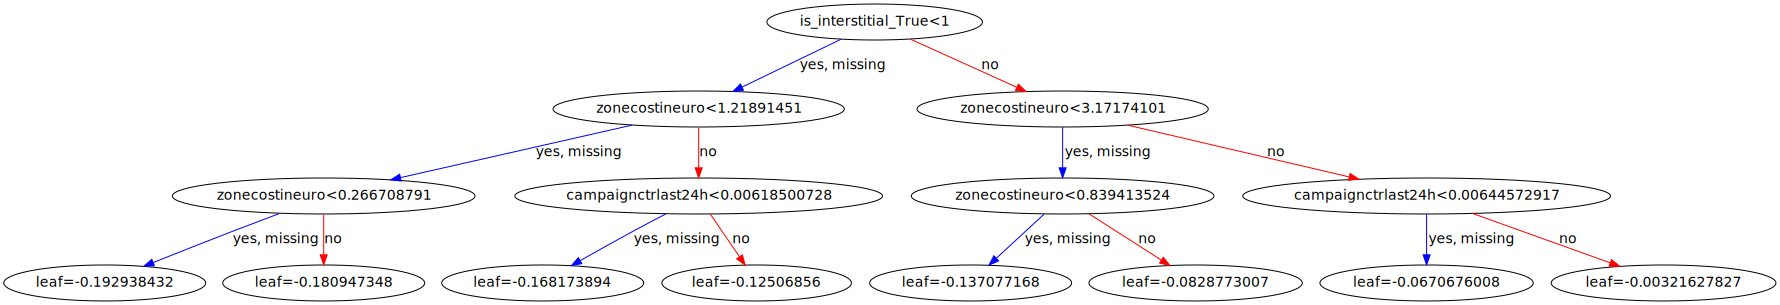

In [16]:
m.show_graph()

## Tuning des hyperparamètres avec GridSearchCV

On calcule le GridSearchCV sur un dataset plus petit pour avoir un temps de calcul raisonnable.

### Calcul et sauvegarde

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [17]:
model = XGBClassifier(booster='gbtree', objective='binary:logistic', n_jobs=1)

cv_params = {
        'n_estimators': [50, 100, 150, 200, 300],    
        'max_depth': [2, 4, 6, 8, 10],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'min_child_weight': [1, 3, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],    
        'scale_pos_weight': [1, 16.5]   # A typical value to consider: sum(negative instances) / sum(positive instances)
        }

print(len(ParameterGrid(cv_params)))

54000


In [18]:
# SearchCV(model, cv_params, data_frac=0.02, random=True, n_iter=10000, random_state=0, n_jobs=28)

### Restauration des résultats

In [19]:
dico, results = restauration_CV('XGBoost_CV_Randomized10000_54000_0.02')

model : XGBClassifier()
model_name : XGBoost
type : RandomizedSearchCV
len_grid : 54000
n_iter : 10000
data_frac : 0.02
temps : 06:28:21
params : {'n_estimators': [50, 100, 150, 200, 300], 'max_depth': [2, 4, 6, 8, 10], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'gamma': [0.5, 1, 1.5, 2, 5], 'min_child_weight': [1, 3, 5, 10], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'scale_pos_weight': [1, 16.5]}
scoring : ['f1', 'recall', 'precision']


In [20]:
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,params,mean_test_f1,std_test_f1,rank_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
0,7.142818,0.089867,0.058750,0.003371,1.0,16.5,300,5,2,0.0001,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.228410,0.011026,4742,0.686965,0.019774,1735,0.137095,0.008049,9354
1,10.017563,0.157182,0.055114,0.000447,0.8,16.5,150,1,4,0.001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.246835,0.009617,4369,0.713887,0.032872,611,0.149357,0.007286,8971
2,5.620645,0.064579,0.042517,0.001523,0.6,16.5,50,10,6,0.1,...,"{'subsample': 0.6, 'scale_pos_weight': 16.5, '...",0.277532,0.005424,2470,0.666486,0.006756,2144,0.175262,0.003885,7285
3,6.177071,0.224936,0.063264,0.001401,1.0,16.5,100,1,6,0.1,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.288410,0.005228,1742,0.613142,0.007361,2697,0.188565,0.004088,6816
4,14.486667,0.217144,0.086738,0.004053,1.0,1,200,10,8,0.0001,...,"{'subsample': 1.0, 'scale_pos_weight': 1, 'n_e...",0.063613,0.009593,9003,0.033403,0.005265,9012,0.701263,0.124659,82
5,8.902804,0.128034,0.054062,0.001709,0.6,1,100,3,6,0.2,...,"{'subsample': 0.6, 'scale_pos_weight': 1, 'n_e...",0.188371,0.027277,6266,0.114752,0.016406,6235,0.527570,0.086082,3382
6,3.458599,0.026112,0.039998,0.002163,0.8,16.5,50,1,6,0.01,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.275733,0.006821,2588,0.676715,0.020234,1961,0.173154,0.004295,7388
7,3.244898,0.035552,0.030602,0.001459,0.6,1,50,5,6,0.001,...,"{'subsample': 0.6, 'scale_pos_weight': 1, 'n_e...",0.037597,0.009380,9342,0.019394,0.004928,9344,0.652098,0.103733,454
8,6.558153,0.134240,0.047113,0.000896,0.6,16.5,50,5,8,0.001,...,"{'subsample': 0.6, 'scale_pos_weight': 16.5, '...",0.297319,0.005953,1148,0.603437,0.016187,2832,0.197261,0.003594,6539
9,7.862787,0.150376,0.072348,0.002414,1.0,16.5,200,5,4,0.3,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.289236,0.011244,1696,0.556031,0.017070,3238,0.195480,0.008386,6611


**Graphiques XY avec 2 scores**

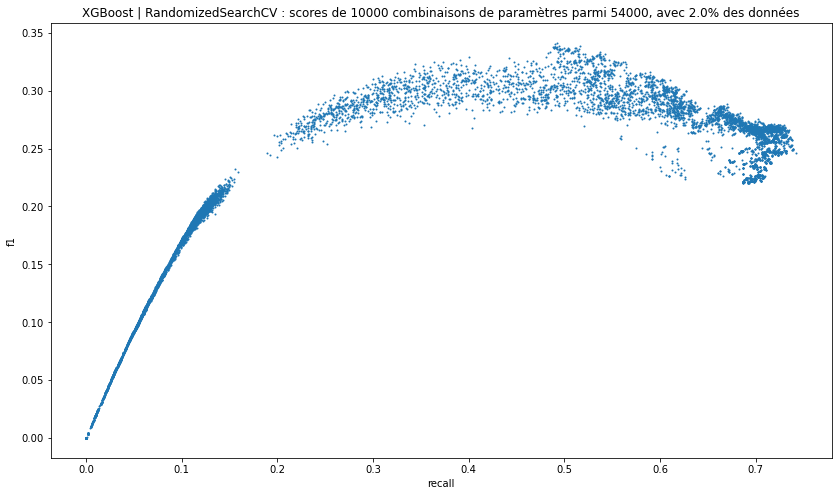

In [21]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=1)

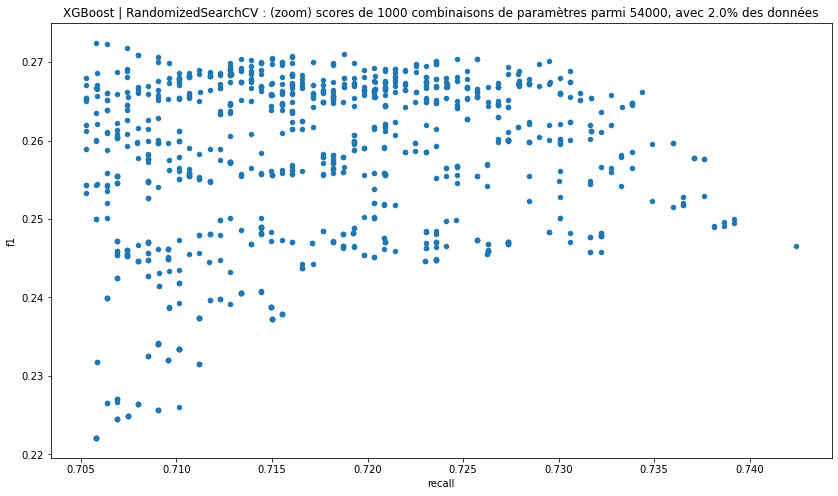

In [22]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=20, zoom=0.1)

**Graphiques de l'effet des paramètres**

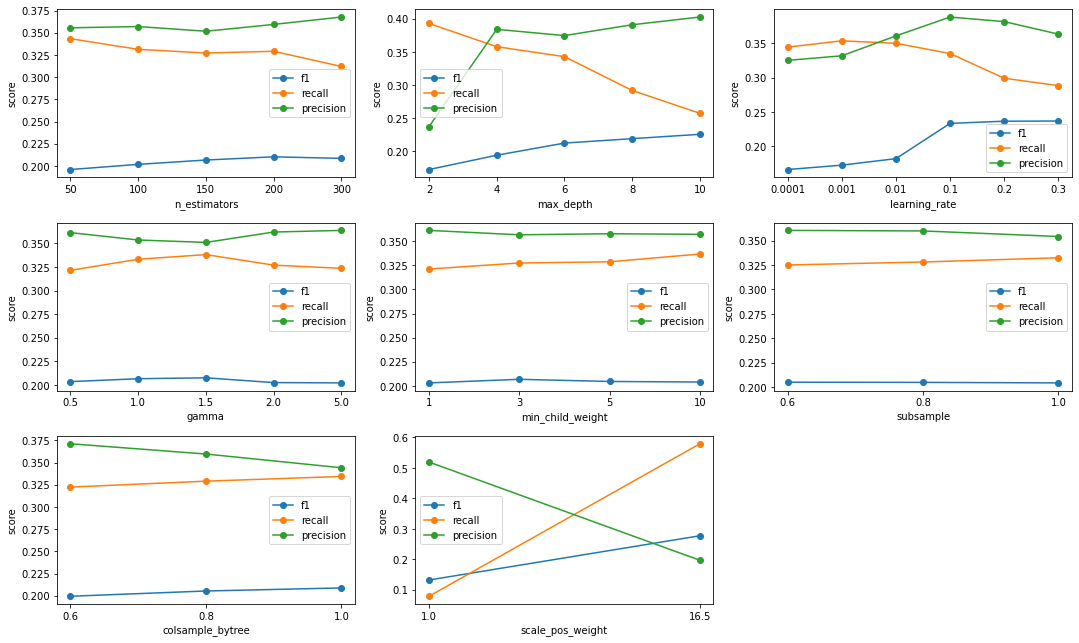

In [23]:
graph_param_CV(dico, results)

**Paramètres donnant le meilleur score**

In [24]:
best_params = best_score_CV(dico, results, 'recall')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,params,mean_test_f1,std_test_f1,rank_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
5100,5.881291,0.086288,0.041165,0.001148,1.0,16.5,100,3,4,0.01,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.246571,0.005695,4380,0.742441,0.016355,1,0.147851,0.003780,9070
5233,8.707440,0.052158,0.052555,0.000580,1.0,16.5,150,10,4,0.01,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.249533,0.005437,4235,0.739208,0.016696,2,0.150120,0.003666,8930
492,6.606247,0.051739,0.043104,0.002552,0.8,16.5,100,10,4,0.01,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.250032,0.004877,4225,0.739207,0.019889,3,0.150479,0.003091,8894
995,8.786964,0.189622,0.054595,0.002448,1.0,16.5,150,10,4,0.01,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.249140,0.005979,4243,0.738669,0.016925,4,0.149860,0.004032,8941
8935,6.696967,0.096349,0.042282,0.001983,0.8,16.5,100,3,4,0.01,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.249589,0.004798,4232,0.738668,0.020582,5,0.150180,0.002980,8924
733,8.714999,0.106239,0.054349,0.001515,1.0,16.5,150,1,4,0.01,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.249054,0.005394,4244,0.738134,0.013679,6,0.149818,0.003734,8946
3787,8.645374,0.108632,0.054059,0.001362,1.0,16.5,150,5,4,0.01,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.248958,0.004956,4245,0.738133,0.014822,7,0.149745,0.003344,8949
4583,1.739793,0.042767,0.025012,0.001073,1.0,16.5,50,3,2,0.1,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.257686,0.004335,4022,0.737604,0.016810,8,0.156120,0.002608,8680
7019,1.714971,0.009068,0.024120,0.000304,1.0,16.5,50,1,2,0.1,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.257589,0.004467,4028,0.737604,0.016810,8,0.156048,0.002686,8688
7547,11.537868,0.077896,0.066329,0.001457,1.0,16.5,200,1,4,0.01,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.252980,0.004381,4174,0.737597,0.015847,10,0.152693,0.003063,8817


{'subsample': 1.0,
 'scale_pos_weight': 16.5,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 4,
 'learning_rate': 0.01,
 'gamma': 5,
 'colsample_bytree': 1.0}

**Analyse sur la base complète**

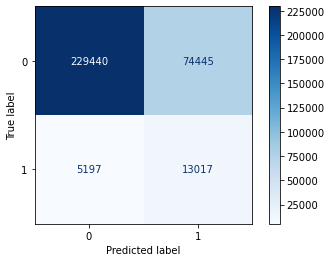

f1 : 0.2464
recall : 0.7147
negative predictive value : 0.9779
precision : 0.1488
roc_auc : 0.8134
CPU times: user 15min 58s, sys: 4.71 s, total: 16min 3s
Wall time: 30.5 s


In [25]:
%%time
m = Modelisation(X, y, XGBClassifier(**best_params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

Le recall est moins bon que celui trouvé auparavant. Essayons avec le `learning_rate` par défaut.

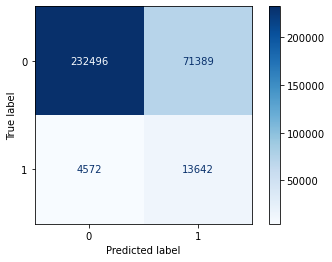

f1 : 0.2643
recall : 0.7490
negative predictive value : 0.9807
precision : 0.1604
roc_auc : 0.8370
CPU times: user 16min 47s, sys: 4.42 s, total: 16min 51s
Wall time: 31.6 s


In [26]:
%%time
if 'learning_rate' in best_params:
    del best_params['learning_rate']
m = Modelisation(X, y, XGBClassifier(**best_params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

Nous reproduisons le graphique f1 vs recall en prenant 10% des meilleures combinaisons (selon le recall), en fittant le modèle sur 10% des données.

  0%|          | 0/50 [00:00<?, ?it/s]

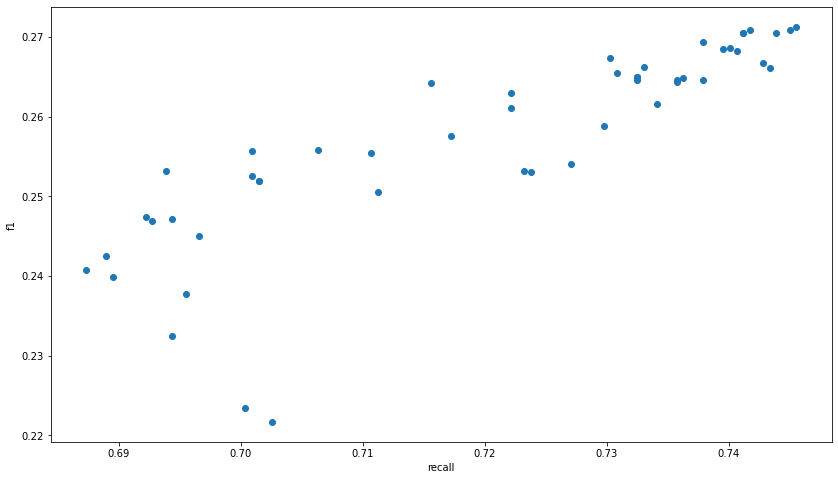

CPU times: user 5h 16min 33s, sys: 54.8 s, total: 5h 17min 28s
Wall time: 6min 57s


In [27]:
 %%time

df_small = pd.read_csv('data/df_train_prepro.csv').sample(frac=0.1)
datasets_df_small = datasets(df_small, verbose=False)
X_small = datasets_df_small['X']
y_small = datasets_df_small['y']

f1_list = []
recall_list = []
params_list = []


results_sort = results.sort_values(by=f'mean_test_recall', ascending=False)


nb_tot = int(0.10 * len(results))
nb = 50

random.seed(1)
sample = random.sample(list(range(nb_tot)), nb)
for j in trange(nb):
    i = sample[j]
    params = results_sort.iloc[i].params
    m = Modelisation(X_small, y_small, XGBClassifier(**params, n_jobs=-1), scaling=False)
    params_list.append(params)
    f1_list.append(m.metrics_score['f1'])
    recall_list.append(m.metrics_score['recall'])
    
plt.figure(figsize=(14, 8))
plt.scatter(recall_list, f1_list, marker='o')
plt.xlabel('recall')
plt.ylabel('f1')
plt.show()
 
# dico_ = {'params': params_list, 'f1': f1_list, 'recall': recall_list}     
# r = pd.DataFrame(dico_).sort_values(by='recall', ascending=False)

Même graphique avec le `learning_rate` par défaut :

  0%|          | 0/50 [00:00<?, ?it/s]

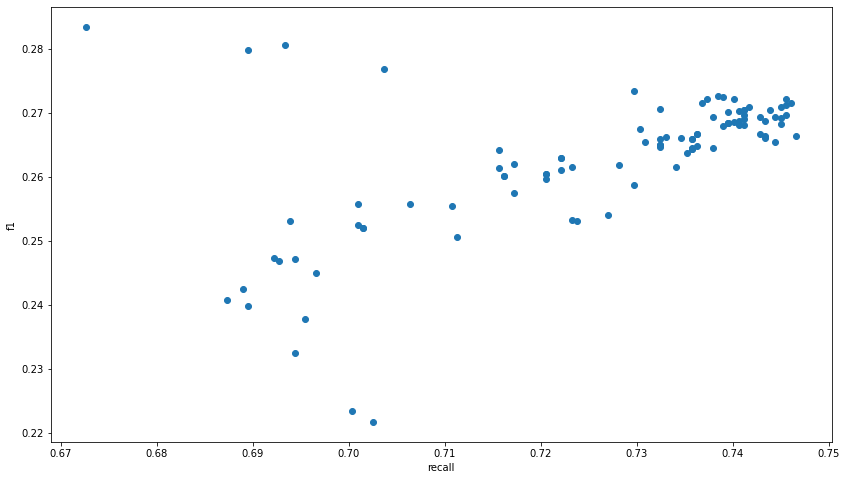

CPU times: user 4h 53min 57s, sys: 52.5 s, total: 4h 54min 49s
Wall time: 6min 13s


In [28]:
%%time

sample = random.sample(list(range(nb_tot)), nb)
for j in trange(nb):
    i = sample[j]
    params = results_sort.iloc[i].params
    if 'learning_rate' in params:
        del params['learning_rate']
    m = Modelisation(X_small, y_small, XGBClassifier(**params, n_jobs=-1), scaling=False)
    params_list.append(params)
    f1_list.append(m.metrics_score['f1'])
    recall_list.append(m.metrics_score['recall'])
    
plt.figure(figsize=(14, 8))
plt.scatter(recall_list, f1_list, marker='o')
plt.xlabel('recall')
plt.ylabel('f1')
plt.show()

**Test de paramètres**

In [29]:
params = {'colsample_bytree': 1.0, 
          'gamma': 1,
          'min_child_weight': 15,
          'scale_pos_weight': 16.5, 
          'subsample': 0.8}

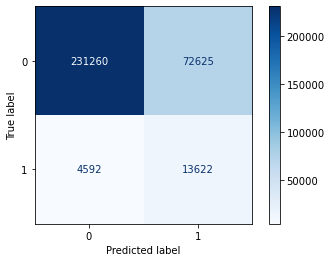

f1 : 0.2608
recall : 0.7479
negative predictive value : 0.9805
precision : 0.1579
roc_auc : 0.8347
CPU times: user 13min 15s, sys: 6.42 s, total: 13min 21s
Wall time: 28.1 s


In [30]:
%%time
m = Modelisation(X, y, XGBClassifier(**params, n_jobs=-1), scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

## Oversampling

In [31]:
df_train_res = pd.read_csv('data/df_train_res.csv').sample(frac=1)
df_test_res = pd.read_csv('data/df_test_res.csv').sample(frac=1)

datasets_df_train_res = datasets(df_train_res, verbose=False)
X_train_res = datasets_df_train_res['X']
y_train_res = datasets_df_train_res['y']

datasets_df_test_res = datasets(df_test_res, verbose=False)
X_test_res = datasets_df_test_res['X']
y_test_res = datasets_df_test_res['y']

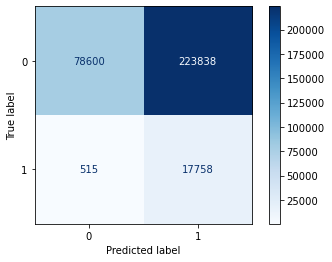

f1 : 0.1367
recall : 0.9718
negative predictive value : 0.9935
precision : 0.0735
roc_auc : 0.8110
CPU times: user 22min 13s, sys: 14.5 s, total: 22min 28s
Wall time: 53.8 s


In [32]:
%%time
m = Modelisation(X_train_res, y_train_res, XGBClassifier(**params, n_jobs=-1), X_test=X_test_res, y_test=y_test_res, scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

In [33]:
# SearchCV(model, cv_params, data_frac=0.01, random=True, n_iter=10000, csv='data/df_train_res.csv', name='res', random_state=0, n_jobs=28)

Problème du gridsearchCV ici, les tests sont effectués sur des données oversamplées, donc les métriques sont faussées.

In [34]:
dico, results = restauration_CV('XGBoost_CV_Randomized100_54000_0.01_res')

model : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
model_name : XGBoost
type : RandomizedSearchCV
len_grid : 54000
n_iter : 100
data_frac : 0.01
temps : 00:02:40
params : {'n_estimators': [50, 100, 150, 200, 300], 'max_depth': [2, 4, 6, 8, 10], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'gamma': [0.5, 1, 1.5, 2, 5], 'min_child_weight': [1, 3, 5, 10], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'scale_pos_weight': [1, 16.5]}
scoring : ['f1', 'recall', 'precision']


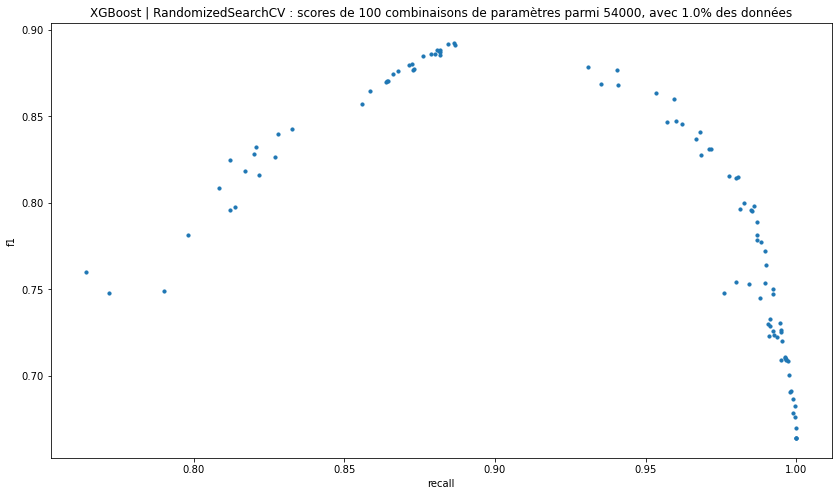

In [35]:
graph_2scores_CV(dico, results, 'recall', 'f1', s=10)

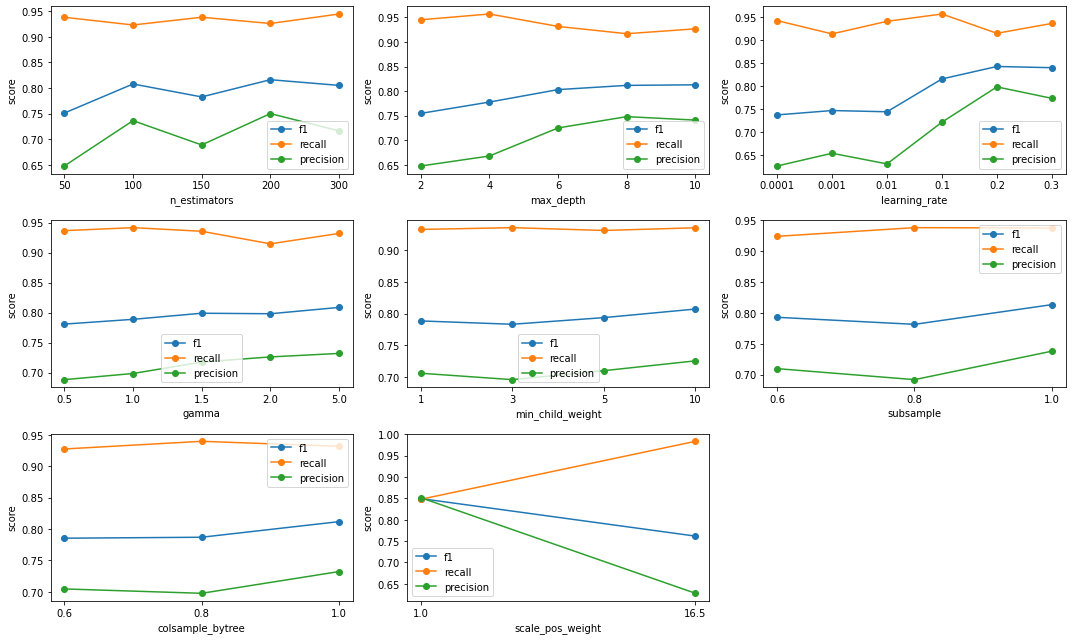

In [36]:
graph_param_CV(dico, results)

In [37]:
best_params = best_score_CV(dico, results, 'recall')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,...,params,mean_test_f1,std_test_f1,rank_test_f1,mean_test_recall,std_test_recall,rank_test_recall,mean_test_precision,std_test_precision,rank_test_precision
50,6.960311,0.147749,0.050453,0.007027,0.8,16.5,200,3,2,0.0001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.664071,0.000069,98,1.000000,0.000000,1,0.497086,0.000077,98
75,2.734533,0.058760,0.035880,0.001165,1.0,16.5,50,3,4,0.0001,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.670086,0.001040,97,1.000000,0.000000,1,0.503857,0.001175,97
72,11.987065,0.123323,0.055391,0.001941,0.8,16.5,300,5,2,0.0001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.664071,0.000069,98,1.000000,0.000000,1,0.497086,0.000077,98
46,6.433679,0.030979,0.040941,0.001220,0.6,16.5,150,1,2,0.0001,...,"{'subsample': 0.6, 'scale_pos_weight': 16.5, '...",0.664071,0.000069,98,1.000000,0.000000,1,0.497086,0.000077,98
41,11.782135,0.202407,0.085459,0.001010,1.0,16.5,150,1,6,0.001,...,"{'subsample': 1.0, 'scale_pos_weight': 16.5, '...",0.682418,0.002106,94,0.999501,0.000407,5,0.518069,0.002388,94
54,2.933330,0.052043,0.035336,0.000583,0.8,16.5,50,3,4,0.001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.676253,0.003701,96,0.999501,0.000806,6,0.511007,0.004371,96
0,4.548964,0.052744,0.034728,0.000529,0.8,16.5,100,3,2,0.01,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.678773,0.003194,95,0.999002,0.000771,7,0.514019,0.003807,95
49,4.317597,0.093706,0.042750,0.000923,0.8,16.5,50,5,6,0.0001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.686575,0.004713,93,0.998753,0.000872,8,0.523103,0.005703,93
79,14.047357,0.247306,0.073106,0.001324,0.8,16.5,200,3,4,0.001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.691046,0.002020,91,0.998088,0.001103,9,0.528479,0.002586,91
65,3.622495,0.092771,0.033892,0.001932,0.8,16.5,50,10,4,0.0001,...,"{'subsample': 0.8, 'scale_pos_weight': 16.5, '...",0.690647,0.001416,92,0.998004,0.000963,10,0.528033,0.001863,92


{'subsample': 0.8,
 'scale_pos_weight': 16.5,
 'n_estimators': 200,
 'min_child_weight': 3,
 'max_depth': 2,
 'learning_rate': 0.0001,
 'gamma': 2,
 'colsample_bytree': 0.6}

/home/headless/work/statapp/tools.py:136: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)


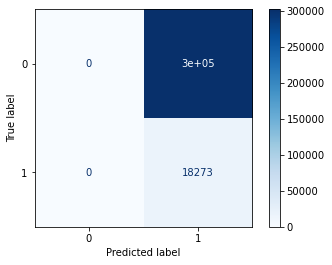

f1 : 0.1078
recall : 1.0000
negative predictive value : nan
precision : 0.0570
roc_auc : 0.7818
CPU times: user 23min 49s, sys: 9.65 s, total: 23min 58s
Wall time: 1min 12s


In [38]:
%%time
m = Modelisation(X_train_res, y_train_res, XGBClassifier(**best_params, n_jobs=-1), X_test=X_test_res, y_test=y_test_res, scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

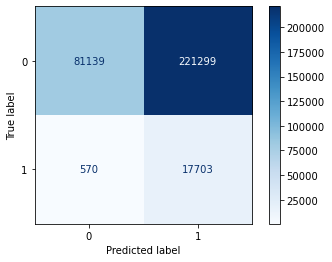

f1 : 0.1376
recall : 0.9688
negative predictive value : 0.9930
precision : 0.0741
roc_auc : 0.8096
CPU times: user 23min 38s, sys: 16.2 s, total: 23min 55s
Wall time: 1min 11s


In [39]:
%%time
if 'learning_rate' in best_params:
    del best_params['learning_rate']
m = Modelisation(X_train_res, y_train_res, XGBClassifier(**best_params, n_jobs=-1), X_test=X_test_res, y_test=y_test_res, scaling=False)
m.show_conf_matrix()
m.show_metrics_score()

In [40]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:19:50
